# NAIRU Model

(Non-accelerating inflation rate of unemployment)

## Acknowledgements

This work has drawn on ideas and approaches in the following:

https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf

https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

https://github.com/MacroDave/NAIRU

https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for OLS

In [2]:
# local imports
from abs_data_capture import (
    get_abs_series, 
)
from rba_data_capture import (
    get_data_table_labels,
    get_data,
)
import plotting

## Data capture

Get the input data, map to quarterly where needed, diff where needed

In [3]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of 
    the three months in each quarter. Ignore quarters with less than 
    three months data. Drop NA items."""

    return (
        data
        .groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(['mean', 'count'])
        .apply(lambda x: x['mean'] if x['count'] == 3 else np.nan, axis=1)
        .dropna()
    )


#### Inflation

In [4]:
def get_π()-> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get the trimmed mean inflation rate (and lagged) from the ABS data."""

    # trimmed mean inflation
    inflation_meta, inflation = get_abs_series(cat_id="6401.0", series_ids=["A3604510W"])
    trimmed_mean = inflation["A3604510W"].dropna()  # Q/Q percent change, seasonally adjusted
    delta_rho = trimmed_mean
 
    # lagged trimmed mean inflation
    delta_rho_1 = delta_rho.shift(periods=1).dropna()
    delta_rho_2 = delta_rho.shift(periods=2).dropna()
    delta_rho_3 = delta_rho.shift(periods=3).dropna()

    return delta_rho, delta_rho_1, delta_rho_2, delta_rho_3


Δρ, Δρ_1, Δρ_2, Δρ_3 = get_π()

#### Inflation expectations (mix of real and synthetic data)

I have serious dobts about the generated synthetic data

Missing values in bond yield:  PeriodIndex(['2013Q2'], dtype='period[Q-DEC]')


<Axes: title={'center': 'QonQ Inflation v Expectations'}>

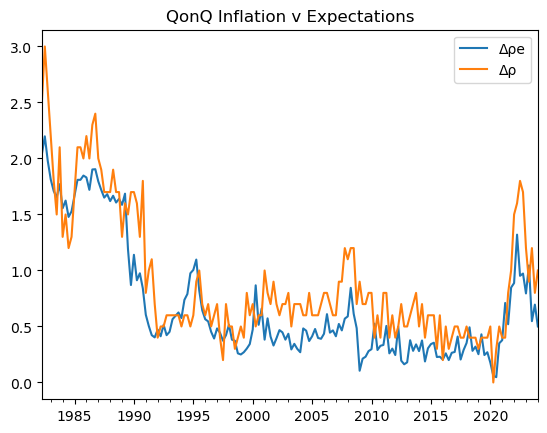

In [5]:
def get_πe(trimmed_mean: pd.Series)-> pd.Series:
    """Get inflation expectations from the RBA data."""

    # inflation expectations from survey
    g3_meta, g3 = get_data("Inflation Expectations – G3")
    expectations = g3["GBUSEXP"].dropna()  # Business inflation expectations – 3-months ahead, per cent per year
    expectations.index = pd.PeriodIndex(expectations.index, freq="Q")

    # Australian Government 10-year bond yield
    bond_yields = pd.read_excel(
        "./NAIRU_INPUTS/RBA_bonds.xls", index_col=0, parse_dates=True, skiprows=10
    )
    bond_yield = monthly_to_quarterly(bond_yields["FCMYGBAG10"])
    # There is a missing value in Q2 2013, so we will interpolate it
    new_by_index = pd.period_range(start=bond_yield.index[0], end=bond_yield.index[-1], freq="Q")
    bond_yield = bond_yield.reindex(new_by_index)
    print("Missing values in bond yield: ", bond_yield[bond_yield.isna()].index)
    bond_yield = bond_yield.interpolate(method="linear", limit_area="inside")

    # let's construct a synthetic inflation expectations series - back as far as the trimmed mean
    # using bond yields, trimmed_mean, and survey data
    X = pd.DataFrame({"annual_bond_yield": bond_yield.loc[expectations.index]})
    X['trimmed'] = trimmed_mean.loc[expectations.index]
    X['time'] = np.arange(1.0, len(X)/10 + 1.0, 0.1)[::-1] 
    X['const'] = 1.0
    X = X.astype(float)
    y = expectations.astype(float)
    model = sm.OLS(y, X)
    fit = model.fit()
    #p = fit.summary()
    #print(p)
    ypred = fit.predict(X)
    # And extrapolate
    last_index = X.index[0] - 1
    first_index = trimmed_mean.index[0]
    index_range = pd.period_range(start=first_index, end=last_index, freq="Q")
    X_out = pd.DataFrame({"annual_bond_yield": bond_yield.loc[index_range]})
    X_out['trimmed'] = trimmed_mean.loc[index_range]
    starting = X.time.iloc[0] + 0.1
    X_out['time'] = np.arange(start=starting, stop=len(X_out)/10 + starting -0.05, step=0.1)[::-1]
    X_out['const'] = 1.0
    oos = fit.predict(X_out) + 2.5  # KLUDGE: add 2.5 to make it look like a real inflation rate
    i_expect = pd.concat([oos, y]).sort_index()
    Δρe = i_expect.dropna() / 4  # roughly convert to quarterly
    return Δρe


Δρe = get_πe(Δρ)
pd.DataFrame({"Δρe": Δρe, "Δρ": Δρ}).plot(title="QonQ Inflation v Expectations")

#### Unemployment rate

<Axes: xlabel='Series ID'>

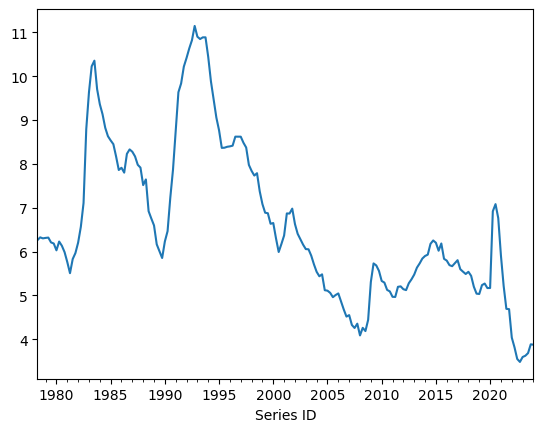

In [6]:

def get_u() -> tuple[pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, and the change in the UE rate
    as a proportion of the UE rate."""

    # get the unemployment rate
    lfs_meta, lfs = get_abs_series(cat_id="6202.0", series_ids=["A84423043C", "A84423047L"])
    employed = lfs["A84423043C"]  # employed persons, thousands, seasonally adjusted
    labour_force = lfs["A84423047L"]  # labour force, thousands, seasonally adjusted
    ue_rate_m = ((1 - employed / labour_force) * 100).dropna()
    ue_rate_q = monthly_to_quarterly(ue_rate_m)

    # calculate the change in the UE rate as a proportion of the UE rate
    delta_U_1_over_U = (ue_rate_q.diff(periods=1) / ue_rate_q).dropna()

    return ue_rate_q, delta_U_1_over_U


U, ΔU_1_over_U = get_u()
U.plot()

<Axes: xlabel='Series ID'>

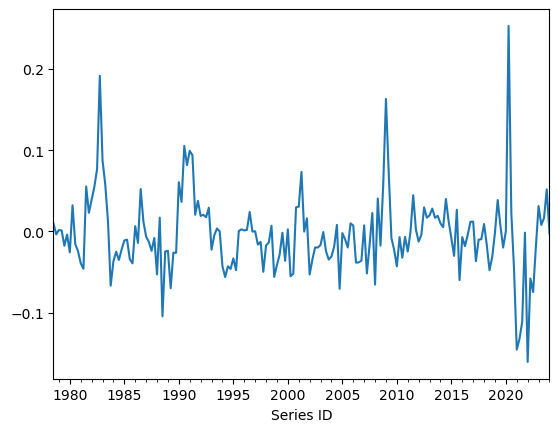

In [7]:
ΔU_1_over_U.plot()

#### Import prices

<Axes: xlabel='Series ID'>

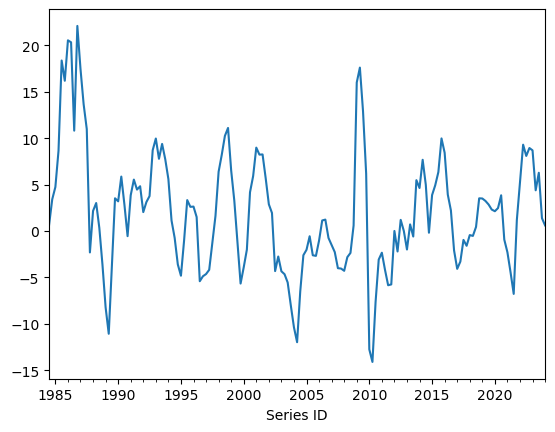

In [8]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade_meta, trade = get_abs_series(cat_id="6457.0", series_ids=["A2298279F"])
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    Δ4ρm_1 = delta4_log_import_prices.shift(periods=1).dropna()
    Δ4ρm_2 = delta4_log_import_prices.shift(periods=2).dropna()

    return Δ4ρm_1, Δ4ρm_2  


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()
Δ4ρm_1.plot()

#### Unit labour costs

<Axes: xlabel='Series ID'>

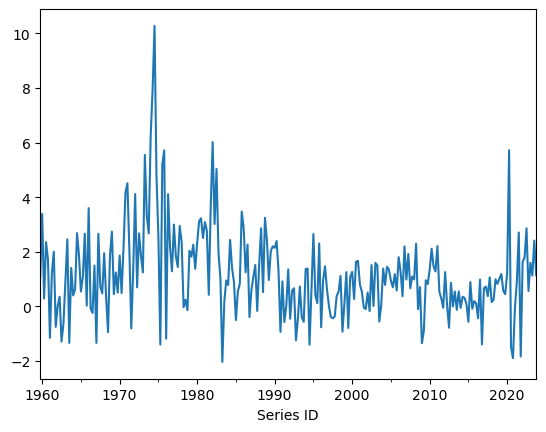

In [9]:

def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts_meta, nat_accounts = (
        get_abs_series(cat_id="5206.0", series_ids=["A2304402X", "A2302915V"])
    )
    ulc = nat_accounts["A2302915V"]/nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100
    return delta_ulc


Δulc = get_ulc()
Δulc.plot()

#### Global supply disriptions

<Axes: xlabel='Date'>

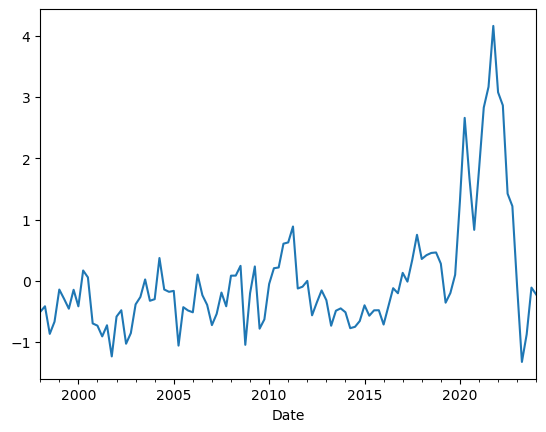

In [10]:
def get_gscpi() -> pd.Series:
    """Global Supply Chain Price Index.
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls", sheet_name="GSCPI Monthly Data", 
        index_col=0, parse_dates=True
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    return gscpi, gscpi_1, gscpi_2


gscpi, gscpi_1, gscpi_2 = get_gscpi()
gscpi.plot()

## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [11]:
def build_obs() -> dict[str, np.ndarray]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Beacuse the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    start = pd.Period("1986Q1", freq="Q")

    observed = pd.DataFrame(
        {
        "Δρ": Δρ,                       # trimmed mean inflation
        "Δρ_1": Δρ_1,                   # lagged trimmed mean inflation
        "Δρ_2": Δρ_2,
        "Δρ_3": Δρ_3, 
        "Δρe": Δρe,                     # inflation expectations
        "U": U,                         # unemployment rate
        "ΔU_1_over_U": ΔU_1_over_U,     # change in UE rate as a proportion of UE rate
        "Δ4ρm_1": Δ4ρm_1,               # annual change in import prices,
        "Δ4ρm_2": Δ4ρm_2,               # annual change in import prices, lagged 1 period
        "Δulc": Δulc,                   # unit labour costs growth
        "gscpi": gscpi,                 # global supply chain price index
        "gscpi_1": gscpi_1,             # global supply chain price index, lagged ny 1 period
        "gscpi_2": gscpi_2,             # global supply chain price index, lagged ny 2 period
        }
    )
    observed = observed[observed.index >= start]
    observed['gscpi_dummy'] = (
        observed['gscpi_2'].isna().astype(float) # missing gscpi data
    )
    #observed['const'] = 1.0
    for col_name in observed.columns:
        if "gscpi" in col_name:
            observed[col_name] = observed[col_name].fillna(0)
    observed = observed.dropna(how="any")  # Note ulc comes from Nat Accounts, which is delayed data
    print(f"Number of months: {len(observed)}; concluding: {observed.index[-1]}")

    return {x: y.to_numpy() for x, y in observed.items()}, observed.index


obs, obs_index = build_obs()

Number of months: 152; concluding: 2023Q4


## Bayesian model

#### The PyMC model

In [12]:
def inflation_equation(
    input: dict[str, np.ndarray], 
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
) -> None:
    """Inflation likelihood equation."""
    
    with model:
        # priors
        alpha_mp_inf = pm.Normal("alpha_mp_inf", mu=0.005, sigma=0.001) # highly constrained
        beta_𝝿1_inf = pm.Normal("beta_𝝿1_inf", mu=0.24, sigma=0.1)
        beta_𝝿2_inf = pm.Normal("beta_𝝿2_inf", mu=0.16, sigma=0.1)
        beta_𝝿3_inf = pm.Normal("beta_𝝿3_inf", mu=0.18, sigma=0.1)
        gamma_ue_gap_inf = pm.Normal("gamma_ue_gap_inf", mu=0, sigma=2) # relatively unconstrained
        delta_𝝿e_inf = pm.Normal("delta_𝝿e_inf", mu=0.35, sigma=0.1)
        lambda_ur_inf = pm.Normal("lambda_ur_inf", mu=0.5, sigma=0.1)

        #gsc_inf_1 = pm.Normal("gsc_inf_1", mu=0.5, sigma=0.1)
        #gsc_sq_inf_1 = pm.Normal("gsc_sq_inf_1", mu=0, sigma=1) 
        #gsc_inf_2 = pm.Normal("gsc_inf_2", mu=0, sigma=1)
        #gsc_sq_inf_2 = pm.Normal("gsc_sq_inf_2", mu=0, sigma=1) 
        #gsc_dummy_inf = pm.Normal("gsc_dummy_inf", mu=0, sigma=1)

        #measurement_inf = pm.Normal("measurement_inf", mu=0.0, sigma=0.3)  # measurement error
        measurement_inf = 0.2  # fixed measurement error for now

        # likelihood
        observed_inf = pm.Normal(
            "observed_inf",
            mu =
            alpha_mp_inf * (input["Δ4ρm_1"] - input["Δ4ρm_2"])  # import prices
            + beta_𝝿1_inf * input["Δρ_1"] + beta_𝝿2_inf * input["Δρ_2"] + beta_𝝿3_inf * input["Δρ_3"]  # lagged inflation
            + gamma_ue_gap_inf * ((input["U"] - nairu)/input["U"])  # unemployment gap
            + delta_𝝿e_inf * input["Δρe"]  # inflation expectations
            + lambda_ur_inf * input["ΔU_1_over_U"]  # change in the unemployment rate
            #+ gsc_inf_1 * input["gscpi_1"] # Not sure
            #+ gsc_sq_inf_1 * input["gscpi_1"]**2  # global supply chain, lag 1
            #+ gsc_inf_2 * input["gscpi_2"] 
            #+ gsc_sq_inf_2 * input["gscpi_2"]**2  # global supply chain, lag 2
            #+ gsc_dummy_inf * input["gscpi_dummy"]  # missing gscpi data
            ,
            sigma=measurement_inf,
            observed=input["Δρ"],
        )

def wage_growth_equation(
    input: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk
) -> None:
    """Wage growth likelihood equation."""

    with model:
        # priors
        delta_lab = pm.Normal("delta_lab", mu=-0.45, sigma=0.21)
        #omega_lab = pm.Normal("omega_lab", mu=0.4, sigma=0.5)
        gamma_ue_gap_lab = pm.Normal("gamma_lab", mu=-1.9, sigma=0.5)
        lambda_lab = pm.Normal("llambda_lab", mu=-5.6, sigma=2.0)
        #const_lab = pm.Normal("const_lab", mu=0.0, sigma=10)

        # likelihood
        observed_lab = pm.Normal(
            "observed_lab",
            mu = 
            delta_lab * input["Δρe"] # inflation expectations
            #+ omega_lab * (input["Δρ_1"] +  input["Δρ_2"])  
            + gamma_ue_gap_lab * ((input["U"] - nairu)/input["U"])
            + lambda_lab * input["ΔU_1_over_U"]
            #+ const_lab
            ,
            sigma=0.5,
            observed=input["Δulc"],
        )

def nairu_equation(input: dict[str, np.ndarray], model) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU."""

    with model:
        # priors
        nairu_start = pm.Normal.dist(mu=5, sigma=2)
        #nairu_innovation = pm.Normal("nairu_innovation", mu=0.2, sigma=0.1)
        nairu_innovation = 0.2  # fixed innovation for now
        nairu = pm.GaussianRandomWalk(
            "nairu",
            mu=0,  # no drift in this model
            sigma=nairu_innovation,
            init_dist=nairu_start,
            steps=len(input["U"])-1,
        )
    return nairu


def define_model(input: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    nairu = nairu_equation(input, model)
    inflation_equation(input, model, nairu)
    #wage_growth_equation(input, model, nairu)        

    return model


model = define_model(input=obs)

#### Generate a map of the model

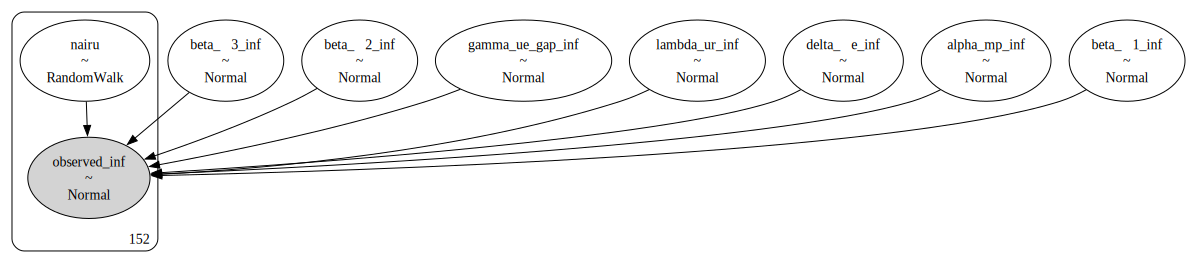

In [13]:
def produce_model_map(m: pm.Model) -> None:
    """Produce a map of the model."""
    
    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=("./NAIRU_INPUTS/nairu model"),
    )
    display(gv)


produce_model_map(model)

#### Fit the model to the data

In [14]:
N_CORES: int = 8
SAMPLES: int = 80_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 2_000

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
}

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 120703 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL PI}) missing from current font.
  func(*args, **kwargs)
/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 120703 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL PI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


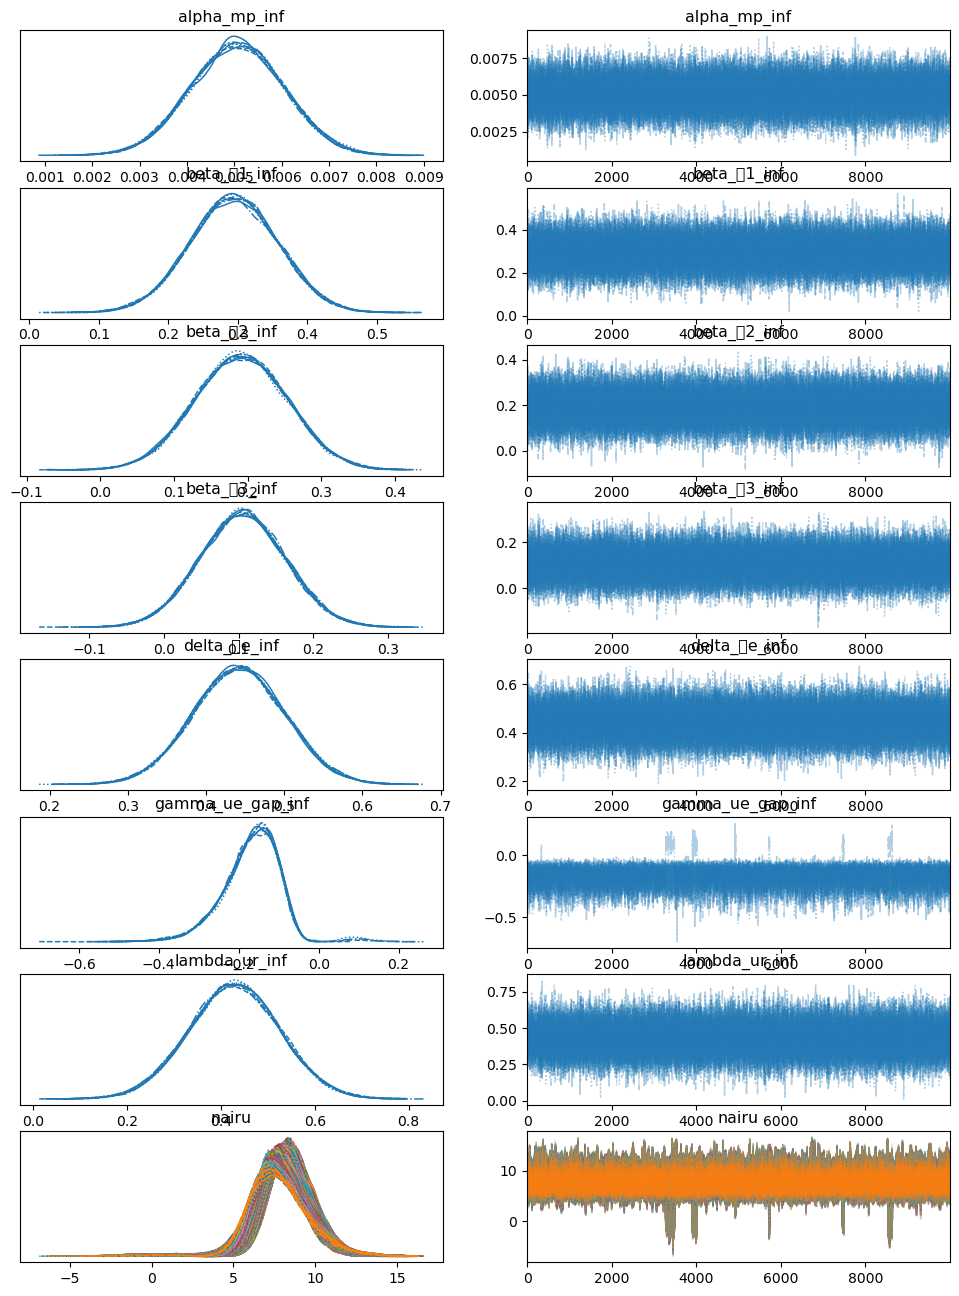

In [15]:
def fit_the_model(model: pm.Model) -> az.InferenceData:
    """Fit the data to the model."""
    
    with model:
        idata = pm.sample(
            **SAMPLE_ARGS,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata


trace = fit_the_model(model)

## Check diagnostics

In [16]:
def check_trace(trace: az.InferenceData) -> None:
    """Check the trace for potential problems."""

    def warn(w: bool) -> str:
        return '--- THERE BE DRAGONS ---> ' if w else ''
    
    summary = az.summary(trace)

    max_r_hat = 1.01
    statistic = summary.r_hat.max()
    print(f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}")

    min_ess = 400
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {statistic}")

    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))
    except (ValueError, AttributeError):  # No sample_stats, or no .diverging
        diverging_count = 0
    print(f"{warn(diverging_count > 0)}Divergent transitions in HMC sampling: {diverging_count}")  


check_trace(trace)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 4302.0
Divergent transitions in HMC sampling: 0


## Results

In [17]:
# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/NAIRU/"
plotting.set_chart_dir(CHART_DIR)
plotting.clear_chart_dir(CHART_DIR)

# display charts in this notebook
SHOW = False

In [18]:
def get_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )

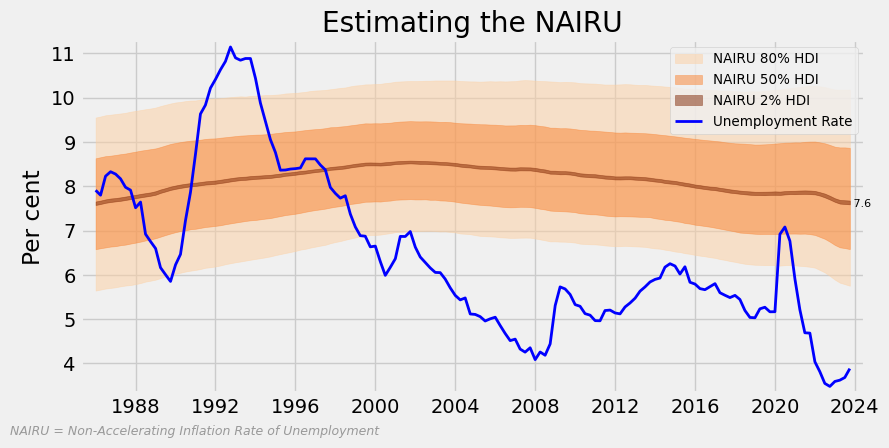

In [19]:
def plot_nairu(
    trace: az.InferenceData,
    obs: dict[str, np.ndarray],
    obs_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    nairu = get_var("nairu", trace)
    nairu.index = obs_index.to_timestamp()
    PERCENTS = [10, 25, 49]
    _COLORS = [(p - min(PERCENTS)) / (max(PERCENTS) - min(PERCENTS)) for p in PERCENTS]
    MIN_COLOR = 0.25
    COLOR_FRACS = [c * (1.0 - MIN_COLOR) + MIN_COLOR for c in _COLORS]
    palette = "Oranges"
    _, ax = plt.subplots()
    cmap = plt.get_cmap(palette)

    for i, p in enumerate(PERCENTS):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        color = COLOR_FRACS[i]
        ax.fill_between(
            nairu.index,
            upper,
            lower,
            color=cmap(color),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )
    ax.plot(
        obs_index.to_timestamp(),
        obs["U"],
        color="blue",
        lw=2,
        label="Unemployment Rate",
        zorder=10,
    )
    latest = round(nairu.iloc[-1].quantile(0.5), 1)
    ax.text(nairu.index[-1], latest, f" {latest}", va="center", ha="left", color="black", fontsize=8)
    plotting.finalise_plot(
        ax,
        title="Estimating the NAIRU",
        ylabel="Per cent",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter="NAIRU = Non-Accelerating Inflation Rate of Unemployment",
        show=True,
    )


plot_nairu(trace, obs, obs_index)

In [20]:
def print_parameter_summary() -> None:
    """Print the summary results of the model,
       useful for non-vector free variables in the model."""

    q = [0.02, 0.5 , 0.98]  
    print(f"{(q[-1] - q[0]) * 100:0.0f}% HDI for the model parameters:")
    results = {str(name): (
        az.extract(trace, var_names=str(name))
        .to_dataframe()[str(name)]
        .quantile(q)) for name in model.free_RVs
        if str(name) not in ["nairu"]
    }
    display(pd.DataFrame(results).T.sort_index())


print_parameter_summary()

96% HDI for the model parameters:


,0.02,0.50,0.98
alpha_mp_inf,0.003054,0.005065,0.007073
beta_𝝿1_inf,0.163706,0.294300,0.423784
beta_𝝿2_inf,0.061925,0.190817,0.319995
beta_𝝿3_inf,-0.011631,0.105522,0.224703
delta_𝝿e_inf,0.322022,0.442204,0.563459
gamma_ue_gap_inf,-0.335926,-0.161929,-0.059634
lambda_ur_inf,0.229141,0.428206,0.626833
